This notebook is used to try out new implementations and to make sure new ideas
work as expected.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from pydantic import BaseModel, computed_field, validate_call, Field, ConfigDict
from typing import Literal, List
import time
import matplotlib.pyplot as plt

class Interpolator(BaseModel,
                   arbitrary_types_allowed=True,
                   validate_assignment=True):
    y: np.ndarray
    x: np.ndarray
    kind: Literal['linear', 'nearest', 'nearest-up', 'zero', 'slinear', \
                  'quadratic', 'cubic', 'previous', 'next'] = 'linear'

    @computed_field
    @property
    def interp_func(self) -> int:
        func = interp1d(self.x, self.y, 
                        kind=self.kind,
                        bounds_error=False,
                        fill_value='extrapolate')
        return func
    
    def value(self, x_new):
        return self.interp_func(x_new)

x = np.arange(11)
y = x ** 2

interpol = Interpolator(x=x, y=y)
x_preds0 = np.linspace(0,5,100)
start_time = time.time()
print('Interpolation not performed')
y_preds00 = interpol.value(x_preds0)
print(time.time() - start_time)
print('Interpolation (hopefully) cached')
x_preds1 = np.linspace(5,10,100)
start_time = time.time()
y_preds10 = interpol.value(x_preds1)
print(time.time() - start_time)
print('Changing y_values')
print('Interpolation not performed')
y_new = (x ** 3) / 8
interpol.y = y_new
start_time = time.time()
y_preds01 = interpol.value(x_preds0)
print(time.time() - start_time)
print('Interpolation (hopefully) cached')
start_time = time.time()
y_preds11 = interpol.value(x_preds1)
print(time.time() - start_time)

Interpolation not performed
0.0003829002380371094
Interpolation (hopefully) cached
5.2928924560546875e-05
Changing y_values
Interpolation not performed
4.482269287109375e-05
Interpolation (hopefully) cached
4.100799560546875e-05


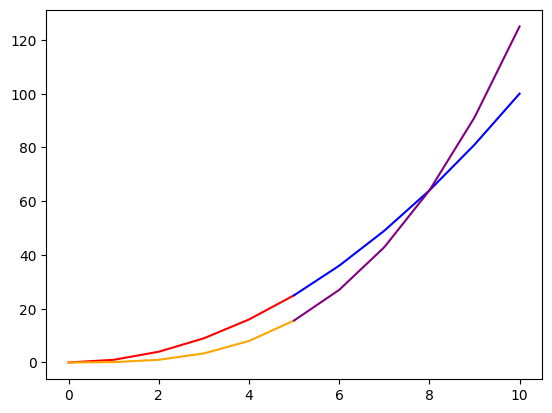

In [15]:
plt.plot(x_preds0, y_preds00, color='red')
plt.plot(x_preds1, y_preds10, color='blue')
plt.plot(x_preds0, y_preds01, color='orange')
plt.plot(x_preds1, y_preds11, color='purple')

In [16]:
func = interp1d([1,2,3], [1,4,9], bounds_error=False, fill_value='extrapolate')
func([1.5, 2.5])

array([2.5, 6.5])

In [17]:
a = [1,2]
b = 3
c = []
d = [4,5]
a.append(b)
print(a)
a.append(c)
print(a)
a.append(d)
print(a)


[1, 2, 3]
[1, 2, 3, []]
[1, 2, 3, [], [4, 5]]


In [18]:
from typing import Literal, Union

class Dummy(BaseModel):
    a: Union[Literal[False], Literal['a']]


b = Dummy(a=0)

In [19]:
from asoh.models.base import *
import numpy as np

class Dummy(HealthVariable, 
            arbitrary_types_allowed=True,
            validate_assignment=True):
    a: Union[float, List]
    b: Union[float, List]
    c: Union[float, List]

test = Dummy(base_values=[1,2,3],
             a = [4,5,6],
             b = 7,
             c = [8,9],
             updatable=('a', 'b', 'c') # ('base_values','a', 'b', 'c') # ('b',) # 
             )
print(test.updatable_len)
print(test.get_updatable_parameter_values())
test.c.append(10)
print(test.updatable_len)
print(test.get_updatable_parameter_values())
test.update(new_values=[10,11,12, 7.5], parameters=('a','b'))
print(test.updatable_len)
print(test.get_updatable_parameter_values())

6
[4, 5, 6, 7.0, 8, 9]
7
[4, 5, 6, 7.0, 8, 9, 10]
7
[10, 11, 12, 7.5, 8, 9, 10]


In [20]:
class DumDummy(BaseModel):
    a: Union[float, List, np.ndarray] = Field(allow_mutation=True)
    b: str = Field(allow_mutation=False)
    class Config:
        arbitrary_types_allowed=True
        validate_assignment=True

    @validate_call(config=ConfigDict(arbitrary_types_allowed=True))
    def update(self, val: Union[float, List, np.ndarray]):
        self.a = val

test = DumDummy(a=np.array([2,3]), b='b')
print(test.a)
test.update(np.array([4,5]))
print(test.a)
# test.b = 'b'

[2 3]
[4 5]


In [21]:
a = np.array([1,2,3])
print(a.tolist())
b = a[:]
print(b)
print(np.array(b))

[1, 2, 3]
[1 2 3]
[1 2 3]


In [22]:
str(('a', 'b', 'cd'))

"('a', 'b', 'cd')"

In [23]:
b[1:2]

array([2])

In [24]:
class Dummy(BaseModel, validate_assignment=True):
    a: float

    @property
    def a(self) -> float:
        return 0.5 * self._2a

    @a.setter
    def a(self, val: float) -> None:
        self._2a = 2 * val

test = Dummy(a = 5)
print(test.a)
test.a = 'a'

5.0


ValidationError: 1 validation error for Dummy
a
  Input should be a valid number, unable to parse string as a number [type=float_parsing, input_value='a', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/float_parsing

In [25]:
a = np.array([123,4, np.pi, 1+2j]) # '123'
import numbers
[isinstance(val, numbers.Number) for val in a]

[True, True, True, True]

In [26]:
from asoh.models.ecm import SeriesResistance

r0 = SeriesResistance(base_values=1, temperature_dependence_factor=1.0e-03)
r0.updatable += ('temperature_dependence_factor',)
# r0.interpolation_style = 3
r0.get_updatable_parameter_values()

ImportError: cannot import name 'SeriesResistance' from 'asoh.models.ecm' (/Users/vventuri/Library/CloudStorage/Dropbox/Argonne/Code/auto-soh/asoh/models/ecm.py)

In [27]:
from typing import Any
from pydantic import Field, BaseModel
from pydantic.json_schema import SkipJsonSchema

class Parent(BaseModel):
    a: str = 'a'

class Child(Parent):
    a: SkipJsonSchema[str] = Field('a', exclude=True)
    b: str = 'b'
    c: str = Field('c') # , exclude=True) #

    def model_post_init(self, __context: Any) -> None:
        del self.model_fields['a']
        delattr(self, 'a')
        return super().model_post_init(__context)

parent = Parent()
print('Parent')
print(parent.model_fields.keys())
print('----------------------------')
child = Child()
print('Child')
print(child.model_fields.keys())
print(child.model_dump())
print(child.model_json_schema())
print(isinstance(child, Parent))
print(child.a)

Parent
dict_keys(['a'])
----------------------------
Child
dict_keys(['b', 'c'])
{'b': 'b', 'c': 'c'}
{'properties': {'b': {'default': 'b', 'title': 'B', 'type': 'string'}, 'c': {'default': 'c', 'title': 'C', 'type': 'string'}}, 'title': 'Child', 'type': 'object'}
True


AttributeError: 'Child' object has no attribute 'a'

In [28]:
child.model_config

{}

In [29]:
child.model_fields

{'b': FieldInfo(annotation=str, required=False, default='b'),
 'c': FieldInfo(annotation=str, required=False, default='c')}

In [30]:
from pydantic.version import version_info as pydantic_v_info
print(pydantic_v_info())


             pydantic version: 2.7.4
        pydantic-core version: 2.18.4
          pydantic-core build: profile=release pgo=false
                 install path: /Users/vventuri/python_envs/ASOH_Diagnostics/lib/python3.9/site-packages/pydantic
               python version: 3.9.6 (default, Feb  3 2024, 15:58:27)  [Clang 15.0.0 (clang-1500.3.9.4)]
                     platform: macOS-14.5-arm64-arm-64bit
             related packages: typing_extensions-4.12.2
                       commit: unknown


In [31]:
from typing import Sized
class FakeList():
    def __init__(self, a):
        self.a = a

    def __len__(self):
        return self.a
    
    def __add__(self, value):
        return value + self.a
    
test = FakeList(5)
print(len(test))
print(test + 2)
print(test.a)
isinstance(test, Sized)

5
7
5


True

In [32]:
a = np.array([1,2,3])
b = getattr(a, 'update', None)
b

In [33]:
callable(None)

False

In [1]:
import numpy as np
from asoh.models.base import *
from asoh.models.ecm import Resistance, Capacitance, RCComponent

r = Resistance(base_values=np.arange(10, dtype=int).tolist())
c = Capacitance(base_values=np.linspace(2000, 2700, 8, dtype=float).tolist())
rc = RCComponent(R=r, C=c) # , updatable=('R',)) # 
print(rc.get_updatable_parameter_values())
print(rc.value(soc=0.5))
print(len(rc))
new_r_vals = [1,2,3,4,5,6,7,8,9,10]
new_c_vals = [11,12,13,14,15,16,17,18]
rc.update(new_values=new_r_vals+new_c_vals) # 37) #, parameters=('R', 'C')) # 
print(rc.value(soc=0.75))
print(rc.get_updatable_parameter_values())
print(rc.model_json_schema()['$defs'].keys())
print(rc.__annotations__)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0, 2500.0, 2600.0, 2700.0]
[array(4.5), array(2350.)]
18
[array(7.75), array(16.25)]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
dict_keys(['Capacitance', 'Resistance'])
{'R': <class 'asoh.models.ecm.Resistance'>, 'C': <class 'asoh.models.ecm.Capacitance'>, 'updatable': typing.Union[typing.Literal[False], tuple[str, ...]], 'name': typing.Optional[str]}


In [2]:
class DummyHVCol(HealthVariableCollection):
    a: HealthVariable
    b: HealthVariable
r2 = Resistance(base_values=[21,22,23])
c2 = Capacitance(base_values=[31,32,33,34,35,36,37], updatable=False)
rc2 = DummyHVCol(a=r2, b=c2)
rc3 = rc + rc2
print(rc3.updatable)
print(rc3.model_fields.keys())
print(rc3.get_updatable_parameter_values())
print(len(rc3))

# rc += rc2
# print(rc.updatable)
# print(rc.get_updatable_parameter_values())
# print(len(rc))

('R', 'C', 'a')
dict_keys(['updatable', 'R', 'C', 'name', 'a', 'b'])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23]
21


In [3]:
rc4 = RCComponent(R=r, C=c)
print(rc4.get_updatable_parameter_values())
print(len(rc4))
print(rc4.model_fields.keys())
print(rc4.updatable)
# print(rc4.a)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
18
dict_keys(['updatable', 'R', 'C'])
('R', 'C')


/Users/vventuri/Library/CloudStorage/Dropbox/Argonne/Code/auto-soh/asoh/models/base.py:241: UserWarning: Field a was set to None, so it is being removed.
  warn(msg)
/Users/vventuri/Library/CloudStorage/Dropbox/Argonne/Code/auto-soh/asoh/models/base.py:241: UserWarning: Field b was set to None, so it is being removed.
  warn(msg)


In [4]:
print(rc3.updatable)
print(rc3.model_fields.keys())
print(rc3.get_updatable_parameter_values())
print(len(rc3))
print(rc3.a)
print(rc3.model_dump().keys())

('R', 'C', 'a')
dict_keys(['updatable', 'R', 'C'])
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23]
21
base_values=[21, 22, 23] updatable=('base_values',) soc_pinpoints=[] interpolation_style='linear' reference_temperature=25 temperature_dependence_factor=0 updatable_len=3
dict_keys(['updatable', 'R', 'C', 'a', 'b', 'updatable_len'])


In [6]:
bla = rc3 + rc4
bla.get_updatable_parameter_values()

ValueError: Attribute 'R' has already been set! Please use a different name.

In [7]:
test = HealthVariableCollection()
test.model_fields.keys()

dict_keys(['updatable'])

In [5]:
class Dummy(HealthVariable):
    name: str = 'dummy'

pi_HV = Dummy(base_values=np.pi, name='PI')
fib_HV = Dummy(base_values=[1,1,2,3,5,8,13,21], name='Fib')
test = rc + pi_HV
print(test.get_updatable_parameter_values())
test = test + fib_HV
print(test.get_updatable_parameter_values())
test.update(new_values=2*np.pi, parameters=('PI',))
# test.PI.base_values
print(test.get_updatable_parameter_values())
test += test
print(test.get_updatable_parameter_values())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 3.141592653589793]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 3.141592653589793, 1, 1, 2, 3, 5, 8, 13, 21]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 6.283185307179586, 1, 1, 2, 3, 5, 8, 13, 21]


ValueError: Attribute 'R' has already been set! Please use a different name.

In [4]:
rc += [1, 2]
print(rc.get_updatable_parameter_values())

ValidationError: 1 validation error for ValidatorIterator
0
  Input should be a valid dictionary or instance of HealthVariable [type=model_type, input_value=1, input_type=int]
    For further information visit https://errors.pydantic.dev/2.7/v/model_type

In [6]:
new_variable = HealthVariable(base_values=np.pi)

rc.add_health_variable(variable=HealthVariable(base_values=np.pi), name='PI')
print(rc.model_json_schema()['$defs'].keys())
print(rc.__annotations__)
print(rc.updatable)


dict_keys(['Capacitance', 'Dummy', 'HealthVariable', 'Resistance'])
{'R': <class 'asoh.models.ecm.Resistance'>, 'C': <class 'asoh.models.ecm.Capacitance'>, 'updatable': typing.Union[typing.Literal[False], tuple[str, ...]], 'PI': <class 'asoh.models.base.HealthVariable'>, 'Fib': <class '__main__.Dummy'>}
('R', 'C', 'PI')


In [3]:
rc.model_dump()

{'updatable': ('R', 'C', 'PI'),
 'R': {'base_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'updatable': ('base_values',),
  'soc_pinpoints': [np.float64(0.0),
   np.float64(0.1111111111111111),
   np.float64(0.2222222222222222),
   np.float64(0.3333333333333333),
   np.float64(0.4444444444444444),
   np.float64(0.5555555555555556),
   np.float64(0.6666666666666666),
   np.float64(0.7777777777777777),
   np.float64(0.8888888888888888),
   np.float64(1.0)],
  'interpolation_style': 'linear',
  'reference_temperature': 25,
  'temperature_dependence_factor': 0,
  'updatable_len': 10,
  '_interp_func': <scipy.interpolate._interpolate.interp1d at 0x104c482c0>},
 'C': {'base_values': [11, 12, 13, 14, 15, 16, 17, 18],
  'updatable': ('base_values',),
  'soc_pinpoints': [np.float64(0.0),
   np.float64(0.14285714285714285),
   np.float64(0.2857142857142857),
   np.float64(0.42857142857142855),
   np.float64(0.5714285714285714),
   np.float64(0.7142857142857142),
   np.float64(0.8571428571428571),


In [4]:
print(rc.get_updatable_parameter_values())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 3.141592653589793]


In [5]:
rc.add_health_variable(variable=[1,1,2,3,5,8,13], name='Fib')
print(rc.model_json_schema()['$defs'].keys())
print(rc.__annotations__)
print(rc.updatable)
print(rc.get_updatable_parameter_values())

dict_keys(['Capacitance', 'HealthVariable', 'Resistance'])
{'R': <class 'asoh.models.ecm.Resistance'>, 'C': <class 'asoh.models.ecm.Capacitance'>, 'updatable': typing.Union[typing.Literal[False], tuple[str, ...]], 'PI': <class 'asoh.models.base.HealthVariable'>, 'Fib': <class 'asoh.models.base.HealthVariable'>}
('R', 'C', 'PI', 'Fib')
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 3.141592653589793, 1, 1, 2, 3, 5, 8, 13]


In [7]:
if 0 != None:
    print('yes')

yes


In [6]:
rc.__dict__

{'updatable': ('R', 'C'),
 'R': Resistance(base_values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], updatable=('base_values',), soc_pinpoints=[np.float64(0.0), np.float64(0.1111111111111111), np.float64(0.2222222222222222), np.float64(0.3333333333333333), np.float64(0.4444444444444444), np.float64(0.5555555555555556), np.float64(0.6666666666666666), np.float64(0.7777777777777777), np.float64(0.8888888888888888), np.float64(1.0)], interpolation_style='linear', reference_temperature=25, temperature_dependence_factor=0, updatable_len=10),
 'C': Capacitance(base_values=[11, 12, 13, 14, 15, 16, 17, 18], updatable=('base_values',), soc_pinpoints=[np.float64(0.0), np.float64(0.14285714285714285), np.float64(0.2857142857142857), np.float64(0.42857142857142855), np.float64(0.5714285714285714), np.float64(0.7142857142857142), np.float64(0.8571428571428571), np.float64(1.0)], interpolation_style='linear', updatable_len=8),
 'new': HealthVariable(base_values=10.0, updatable=('base_values',), updatable_len=1)}

In [7]:
type(rc.R)

asoh.models.ecm.Resistance

In [8]:
isinstance(rc.R, HealthVariable)

True

In [12]:
'ab' in ['ab_1', 'ab_2', 'a', 'b', 'ab']

True

In [14]:
a = 'a'
b = 'a'
if a is not None:
    print('a')

a


In [15]:
if 'a' is 'a':
    print('yes')

yes


<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/89/mkngtyzs54l121mx93tt09z00000gp/T/ipykernel_96210/1796930161.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if 'a' is 'a':


In [19]:
a = (1,2,3)
a += (4,)
a

(1, 2, 3, 4)

In [24]:
a = [1,2,3]
try:
    a[4] = 4
except IndexError as ie:
    raise Exception('idiot') from None # ie

Exception: idiot

In [25]:
rc.__annotations__

{'R': asoh.models.ecm.Resistance,
 'C': asoh.models.ecm.Capacitance,
 'updatable': typing.Union[typing.Literal[False], tuple[str, ...]]}

In [5]:
rc.new.name

AttributeError: 'HealthVariable' object has no attribute 'name'

In [27]:
rc.__annotations__.update()

In [28]:
rc.__annotations__

{'R': asoh.models.ecm.Resistance,
 'C': asoh.models.ecm.Capacitance,
 'updatable': typing.Union[typing.Literal[False], tuple[str, ...]]}

In [2]:
from typing import Iterable

print(isinstance([1,2,3], Iterable))
print(isinstance((1,2,3), Iterable))
print(isinstance(rc, Iterable))

True
True
True


In [6]:
class Dummy(HealthVariable):
    name: str = 'dummy'
    b: Optional[str]

pi_HV = Dummy(base_values=np.pi, name='PI')
fib_HV = Dummy(base_values=[1,1,2,3,5,8,13,21], name='Fib')
test = rc + pi_HV
print(test.get_updatable_parameter_values())
test = test + fib_HV
print(test.get_updatable_parameter_values())
test.PI.update(new_values=[np.pi, 2*np.pi])
test.PI.base_values
# print(test.get_updatable_parameter_values())

ValidationError: 1 validation error for Dummy
b
  Field required [type=missing, input_value={'base_values': 3.141592653589793, 'name': 'PI'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.7/v/missing

In [5]:
import numbers
isinstance(None, numbers.Number)

False

In [12]:
a = False
if a is None:
    print('f')
else:
    print('nice')

nice


In [6]:
from asoh.models.ecm import MaxTheoreticalCapacity
from asoh.models.base import HealthVariableCollection
test = MaxTheoreticalCapacity(base_values=10, name='qt')
dummy = HealthVariableCollection()
print(dummy.updatable)
dummy += test
dummy.Qt

ValidationError: 1 validation error for MaxTheoreticalCapacity
name
  Input should be 'Qt' [type=literal_error, input_value='qt', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/literal_error

In [5]:
dummy.updatable

('Qt',)

In [3]:
dummy.get_updatable_parameter_values()

[36000.0]

In [3]:
import numpy as np
a = np.arange(4)
b = np.arange(4,8)
a*b

array([ 0,  5, 12, 21])

In [4]:
int(True)

1

In [12]:
np.hstack(([1,2], [], 3, (4), (), (5,6,7)))

array([1., 2., 3., 4., 5., 6., 7.])

In [2]:
# from asoh.models.base import *
from asoh.models.ecm import ECMHiddenVector

soc = 0.5
q0 = 0.42
i_rc = [0.29, -1.4]
hyst = -0.083

test = ECMHiddenVector(soc=soc, hyst=hyst,) # i_rc=i_rc,) # 
print(len(test))
print(test.to_numpy())
# test.update(new_values=[0.7, 0.6, 0.5, 0.4, 0.3, 0.2]) 
test.update(new_values=[0.7, 0.2], parameters=('soc', 'hyst'))
print(len(test))
print(test.to_numpy())
test.update(new_values=[0.7, 0.2, 3.14], parameters=('i_rc', 'hyst'))
print(len(test))
print(test.to_numpy())
test.update(new_values=q0, parameters=('q0',))
print(len(test))
print(test.to_numpy())

2
[ 0.5   -0.083]
2
[0.7 0.2]


ValueError: Trying to update ('i_rc', 'hyst') with a total length of 1, but new_values iterable provided has a length of 3!

In [11]:
a = [test.model_copy()] * 5 # [test.model_copy() for _ in range(5)] # 
a[0].update(new_values=0.3, parameters='soc')
print(a)

[ECMHiddenVector(soc=0.3, q0=[], i_rc=[], hyst=0.2), ECMHiddenVector(soc=0.3, q0=[], i_rc=[], hyst=0.2), ECMHiddenVector(soc=0.3, q0=[], i_rc=[], hyst=0.2), ECMHiddenVector(soc=0.3, q0=[], i_rc=[], hyst=0.2), ECMHiddenVector(soc=0.3, q0=[], i_rc=[], hyst=0.2)]


In [9]:
test

ECMHiddenVector(soc=0.7, q0=[], i_rc=[], hyst=0.2)

In [19]:
import numpy as np
a = np.arange(10)
a = a.reshape(10,-1)
np.hstack((a,a))

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5],
       [6, 6],
       [7, 7],
       [8, 8],
       [9, 9]])

In [3]:
from asoh.models.base import InputQuantities

test = InputQuantities(time = 0.0, current=12.,) # temperature=30) #
print(test.names)
print(test.to_numpy())
test = InputQuantities(time = 0.0, current=12., temperature=30) #
print(test.names)
print(test.to_numpy())

('time', 'current', 'temperature')
[ 0. 12.]
('time', 'current', 'temperature')
[ 0. 12. 30.]


In [15]:
a = 1
b = [3 for _ in range(a)]
if b:
    print(b)

[3]


In [17]:
import numpy as np
a = np.array(5)
for i in a:
    print(i)

TypeError: iteration over a 0-d array

In [20]:
from pydantic import BaseModel, Field
class Dummy(BaseModel):
    a: str = Field(default='a')
test = Dummy()
test

Dummy(a='a')

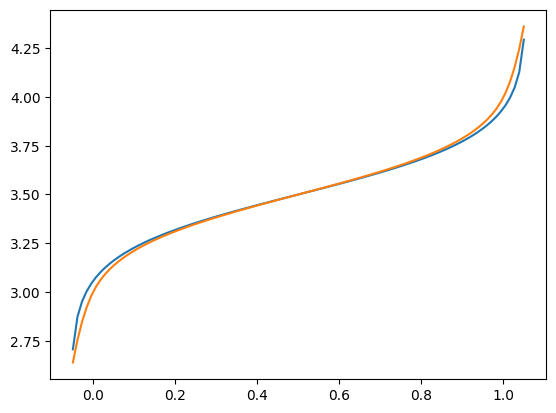

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from asoh.models.ecm import ReferenceOCV, EntropicOCV, OpenCircuitVoltage

x_scale = 0.9
x_off = 0.05
y_scale = 0.15
y_off = 3.5

x = np.linspace(-x_off, 1 + x_off, 100)
mod_x = (x_scale * x) + x_off
y = (y_scale * np.log(mod_x/(1-mod_x))) + y_off
# plt.plot(x,y)
fit_y = y[np.logical_and(x>=-0.025, x<=1.025)]
refOCV = ReferenceOCV(base_values=fit_y, interpolation_style='cubic')
plt.plot(x,y)
plt.plot(x, refOCV.value(x))

In [45]:
a = -5
b = np.where(a>0, a, 10)
b

array(10)

In [53]:
a = None
b = None
c = 5
if a == b:
    print('equal')
sum([i for i in [a,b] if i is not None])

equal


0